# Reinforcement learning with Double_Q-learning(DQN)

## Michał Gromadzki

In [28]:
import tensorflow as tf
import numpy as np
import gym
from collections import deque
import matplotlib.pyplot as plt
tf.random.set_seed(1337)
np.random.seed(1337)

## Loading environment, setting up NNs and ReplayBuffer

In [29]:
#https://www.gymlibrary.dev/environments/classic_control/cart_pole/
env = gym.make('CartPole-v1')
n_features = env.observation_space.shape
n_features

(4,)

In [30]:
n_features = n_features[0]
n_actions = env.action_space.n

In [31]:
n_actions, n_features

(2, 4)

In [39]:
#https://en.wikipedia.org/wiki/Q-learning#Double_Q-learning
main_nn = tf.keras.Sequential([
    tf.keras.layers.Dense(n_features),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(n_actions),
])
target_nn = tf.keras.Sequential([
    tf.keras.layers.Dense(n_features),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(n_actions),
])

In [40]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
mse = tf.keras.losses.MeanSquaredError()

In [41]:
class ReplayBuffer(object):
    def __init__(self, size):
        self.buffer = deque(maxlen=size)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def __len__(self):
        return len(self.buffer)

    def sample(self, num_samples):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        idx = np.random.choice(len(self.buffer), num_samples)
        for i in idx:
            elem = self.buffer[i]
            state, action, reward, next_state, done = elem
            states.append(np.array(state))
            actions.append(np.array(action))
            rewards.append(reward)
            next_states.append(np.array(next_state))
            dones.append(done)
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), np.array(next_states), np.array(dones, dtype=np.float32)

In [42]:
buffer = ReplayBuffer(100000)

In [43]:
def policy(state, epsilon):
    result = tf.random.uniform((1,))
    if result < epsilon:
        return env.action_space.sample() # Random action
    else:
        return tf.argmax(main_nn(state)[0]).numpy() # Best action

In [44]:
@tf.function
def train_step(states, actions, rewards, next_states, dones):
    next_qs = target_nn(next_states)
    max_next_qs = tf.reduce_max(next_qs, axis=-1)
    target = rewards + (1. - dones) * discount * max_next_qs
    with tf.GradientTape() as tape:
        qs = main_nn(states)
        action_masks = tf.one_hot(actions, n_actions)
        masked_qs = tf.reduce_sum(action_masks * qs, axis=-1)
        loss = mse(target, masked_qs)
    grads = tape.gradient(loss, main_nn.trainable_variables)
    optimizer.apply_gradients(zip(grads, main_nn.trainable_variables))
    return loss

## Training

In [45]:
#Hyperparameters
num_episodes = 1000
epsilon = 1.0
batch_size = 4
discount = 0.99
cnt = 0

#Training
last_50_rewards = []
losses = []
all_rewards = []
for episode in range(num_episodes+1):
    state = env.reset()[0]
    episode_reward, done = 0, False
    loss = 0
    while not done:
        state_in = tf.expand_dims(state, axis=0)
        action = policy(state_in, epsilon)
        #https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
        next_state, reward, done = env.step(action)[:3] #step returns: np.array(self.state, dtype=np.float32), reward, terminated, False, {} - last False, {} not useful
        episode_reward += reward
        # Save to experience replay.
        buffer.add(state, action, reward, next_state, done)
        state = next_state
        cnt += 1
        #Copy main_nn weights to target_nn - Double Q-learning
        if cnt % 2000 == 0:
            target_nn.set_weights(main_nn.get_weights())

        #Train neural network
        if len(buffer) >= batch_size:
            states, actions, rewards, next_states, dones = buffer.sample(batch_size)
            loss += train_step(states, actions, rewards, next_states, dones)
            
    losses.append(loss)
    all_rewards.append(episode_reward)
    if (episode+1) % 50 == 0:
        print(f'Episode {episode+1}/{num_episodes} - Epsilon: {epsilon:.3f} - Reward in last 50 episodes: {np.mean(last_50_rewards):.3f}')

    if episode < 950:
        epsilon -= 0.001

    if len(last_50_rewards) == 50:
        last_50_rewards = []
    last_50_rewards.append(episode_reward)
        
env.close()

Episode 50/1000 - Epsilon: 0.951 - Reward in last 50 episodes: 23.980
Episode 100/1000 - Epsilon: 0.901 - Reward in last 50 episodes: 23.367
Episode 150/1000 - Epsilon: 0.851 - Reward in last 50 episodes: 23.837
Episode 200/1000 - Epsilon: 0.801 - Reward in last 50 episodes: 28.245
Episode 250/1000 - Epsilon: 0.751 - Reward in last 50 episodes: 27.490
Episode 300/1000 - Epsilon: 0.701 - Reward in last 50 episodes: 41.531
Episode 350/1000 - Epsilon: 0.651 - Reward in last 50 episodes: 52.122
Episode 400/1000 - Epsilon: 0.601 - Reward in last 50 episodes: 72.327
Episode 450/1000 - Epsilon: 0.551 - Reward in last 50 episodes: 82.082
Episode 500/1000 - Epsilon: 0.501 - Reward in last 50 episodes: 110.714
Episode 550/1000 - Epsilon: 0.451 - Reward in last 50 episodes: 139.878
Episode 600/1000 - Epsilon: 0.401 - Reward in last 50 episodes: 157.163
Episode 650/1000 - Epsilon: 0.351 - Reward in last 50 episodes: 206.714
Episode 700/1000 - Epsilon: 0.301 - Reward in last 50 episodes: 251.224
Ep

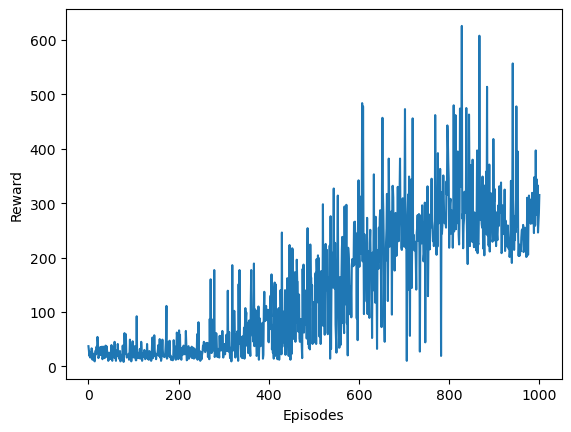

In [53]:
plt.plot(all_rewards)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.show()

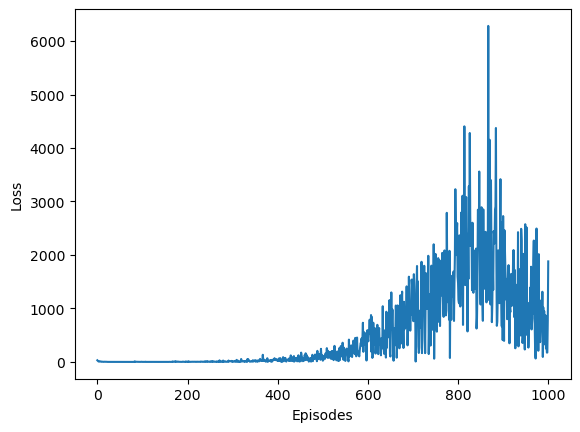

In [55]:
plt.plot(losses)
plt.xlabel("Episodes")
plt.ylabel("Loss")
plt.show()

## Test the policy

In [66]:
def select_action(state, target_nn):
    return tf.argmax(target_nn(state)[0]).numpy()

n_episodes = 50
total_reward = 0
for episode in range(n_episodes):
    state = env.reset()[0]
    done = False
    episode_reward = 0
    actions = []
    while not done:
        state_in = tf.expand_dims(state, axis=0)
        action = select_action(state_in, target_nn)
        actions.append(action)
        next_state, reward, done = env.step(action)[:3]
        episode_reward += reward
        state = next_state
    total_reward += episode_reward

In [67]:
total_reward/n_episodes #The threshold for rewards is 475

360.0